### User Input

In [1]:
mfccs_json_path = "../mfccs_cnn_humpbackwhale_walrus.json"

### Imports

In [13]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import warnings

import cnn_acoustics_lib as cal

### Plot Settings

In [3]:
# color defaults
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Green, CB91_Pink, CB91_Purple, CB91_Violet, CB91_Amber]

# matplotlib seettings
plt.style.use('ggplot')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.style.use('ggplot')

# seaboarn settings
sns.set(style='ticks')
sns.set(style='ticks')
sns.set_style("darkgrid")

# pandas settings
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# warning settings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load MFCC Dataset

In [4]:
X, y, L = cal.load_cnn_json(mfccs_json_path)
print(f"mapping the marine mammals: {L}")

mapping the marine mammals: ['HumpbackWhale' 'Walrus']


In [5]:
# Check class counts and that labels are numerical order
np.unique(y, return_counts=True)

(array([1, 2]), array([1000, 1000]))

### Create Training, Validation, and Test Sets

In [6]:
# create train, validation and test sets
X_train, X_validation, X_test, y_train, y_validation, y_test = cal.prepare_datasets(X, y, 0.25, 0.2) # test size, vailidation size

### Build the Model

In [7]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = cal.build_model(input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

In [8]:
# compile the network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

Epoch 1/40


2023-01-09 22:59:01.170109: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


38/38 [==============================] - 1s 15ms/step - loss: 1.4220 - accuracy: 0.5250 - val_loss: 1.5058 - val_accuracy: 0.5067
Epoch 2/40
38/38 [==============================] - 0s 12ms/step - loss: 0.6497 - accuracy: 0.8475 - val_loss: 1.1946 - val_accuracy: 0.6067
Epoch 3/40
38/38 [==============================] - 0s 10ms/step - loss: 0.3542 - accuracy: 0.9208 - val_loss: 0.7777 - val_accuracy: 0.7900
Epoch 4/40
38/38 [==============================] - 0s 11ms/step - loss: 0.2043 - accuracy: 0.9592 - val_loss: 0.4143 - val_accuracy: 0.9333
Epoch 5/40
38/38 [==============================] - 0s 11ms/step - loss: 0.1666 - accuracy: 0.9650 - val_loss: 0.2010 - val_accuracy: 0.9867
Epoch 6/40
38/38 [==============================] - 0s 11ms/step - loss: 0.1103 - accuracy: 0.9800 - val_loss: 0.1068 - val_accuracy: 0.9933
Epoch 7/40
38/38 [==============================] - 0s 11ms/step - loss: 0.0795 - accuracy: 0.9908 - val_loss: 0.0607 - val_accuracy: 0.9967
Epoch 8/40
38/38 [======

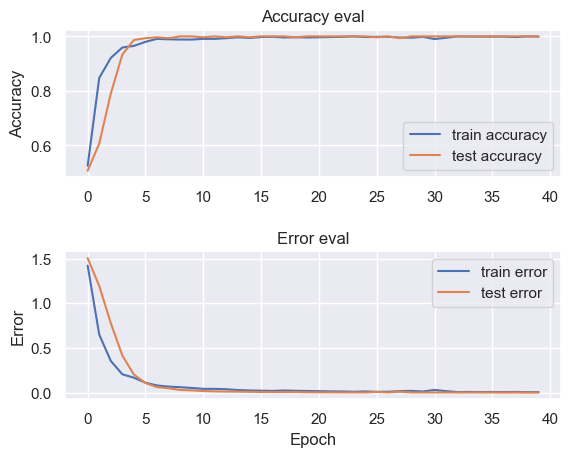

In [9]:
# Train the cnn 
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=40)

# plot accuracy/error for training and validation
cal.plot_history(history)

In [10]:
# evaluate the cnn on the test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy on test set is: {}".format(test_accuracy))

16/16 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 0.9980
Accuracy on test set is: 0.9980000257492065


# Confusion Matrix

In [11]:
# iterate each sample of X_test, predict, and store predicted index into a numpy array.
ypred_array = np.array([])

for i in range(len(X_test)):
    X = X_test[i]
    X = X[np.newaxis, ...] # to make a 4D
    
    # prediction
    prediction = model.predict(X)
    
    # extract the index with the max value
    predicted_index = np.argmax(prediction, axis=1)
    ypred_array = np.append(ypred_array, predicted_index)

print(ypred_array)

1/1 [==============================] - 0s 10ms/step
[2. 2. 1. 2. 2. 1. 1. 2. 2. 1. 1. 1. 2. 1. 2. 2. 2. 1. 1. 1. 1. 1. 2. 1.
 2. 1. 1. 1. 2. 1. 2. 1. 2. 1. 2. 2. 2. 2. 1. 1. 2. 1. 2. 2. 1. 2. 1. 2.
 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 2. 2. 2. 1. 1. 1.
 2. 2. 2. 1. 2. 2. 1. 2. 2. 1. 1. 1. 1. 2. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1.
 2. 2. 2. 1. 1. 2. 1. 2. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 2.
 1. 1. 2. 1. 2. 1. 2. 2. 2. 2. 1. 1. 1. 2. 1. 2. 2. 1. 2. 1. 2. 2. 1. 1.
 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2.
 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 2. 2. 1. 1. 1. 2. 1. 1. 2. 1.
 2. 2. 1. 1. 2. 2. 1. 1. 1. 2. 1. 2. 2. 1. 1. 1. 1. 1. 2. 1. 1. 2. 2. 1.
 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 2. 1. 2. 1. 2. 2. 1. 2. 1. 1.
 1. 1. 2. 2. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 2. 1. 2. 2. 1. 2. 2. 2. 2. 2.
 2. 2. 1. 1. 2. 2. 2. 1. 2. 1. 2. 1. 1. 1. 1. 1. 2. 1. 2. 2. 1. 2. 1. 1.
 1. 2. 1. 2. 1. 2. 1. 2. 1. 1. 2. 1. 1. 2. 1. 2. 1. 1. 1. 1. 2. 2. 2. 1.

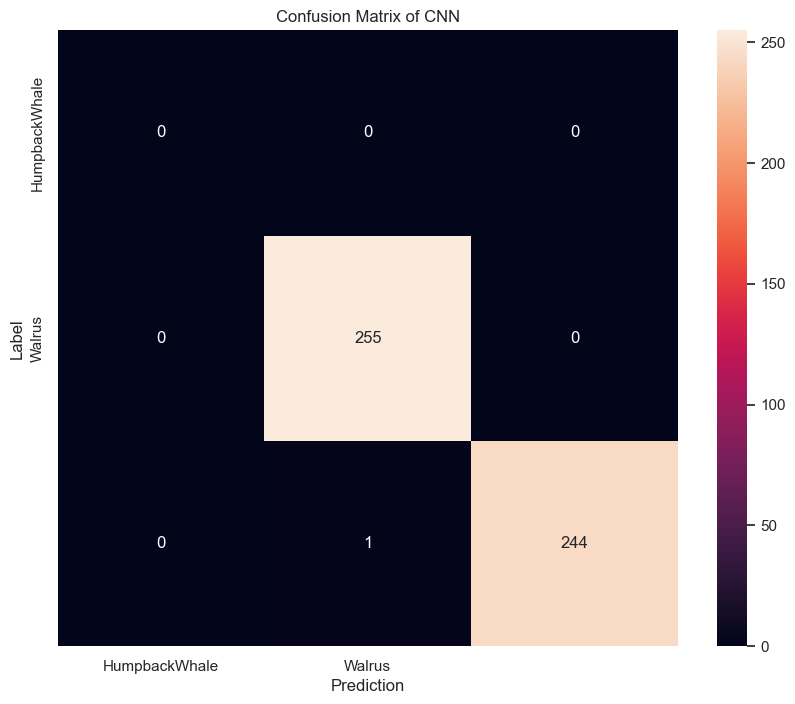

In [14]:
confusion_mtx = tf.math.confusion_matrix(y_test, ypred_array) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=L, yticklabels=L, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion Matrix of CNN")
plt.savefig('/Users/seantedesco/Documents/marine-mammal-call-classification/finalCFcnn.png', bbox_inches='tight')
plt.show();

### Predict a sample

In [ ]:
# make a prediction on a sample
X = X_test[65]
y = y_test[65]
cal.predict(model, X, y)

### Save the model

In [ ]:
# save the entire model
model.save('saved_model/FinalCnnModel6_2')